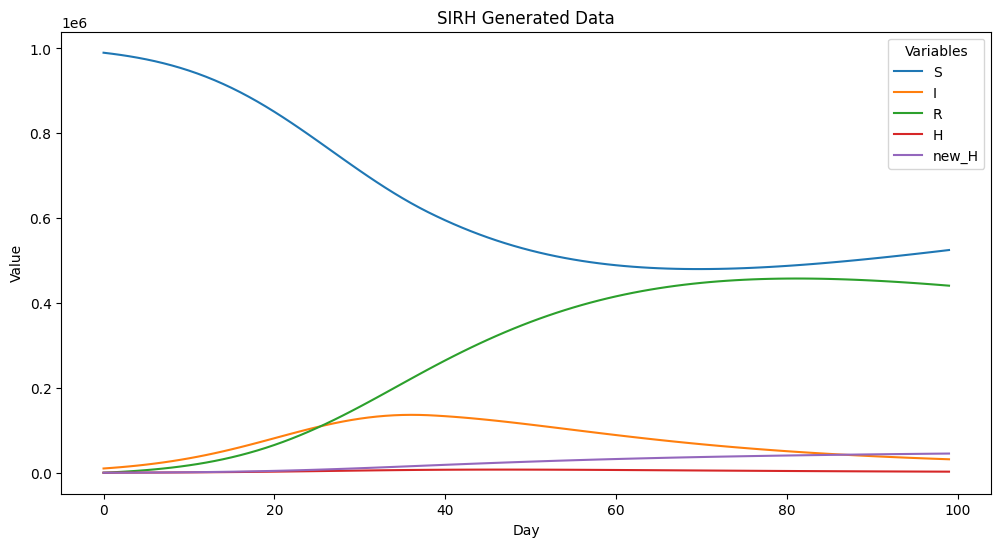

In [1]:
import src.particle_filter.plotting

"""This cell generates synthetic data."""

from src.particle_filter.transition import (
    Transition,
    OUModel,
)
from jax.random import PRNGKey
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

days = 100
step_beta_switch = 40

initial_beta = 0.25
final_beta = 0.15

# Create a linear decline from initial_beta to final_beta
linear_decline = np.linspace(initial_beta, final_beta, step_beta_switch)

# Combine the declining part with the final constant value
step_beta = np.concatenate([linear_decline, [final_beta] * (days - step_beta_switch)])

pop = 1000000
infected = 0.01 * pop
susceptible = pop - infected
initial_state = jnp.array([susceptible, infected, 0, 0, 0, 0.3])
key = PRNGKey(0)

import paths
import os

config_path = os.path.join(paths.PF_DIR, "config.toml")

ou_model = OUModel(config_path)

det_output = [initial_state.copy()]
case_reports = [0]


def det_update(state, time_step):
    state = state.at[5].set(step_beta[time_step])
    update = ou_model.det_component(state, time_step)
    case_reports.append(update[4].item())
    state += update
    return state


for t in range(1, days):
    det_output.append(det_update(det_output[-1], t))


def plot_output(output):
    data = np.array(output)
    labels = ["S", "I", "R", "H", "new_H"]
    # Create a plot for each variable
    plt.figure(figsize=(12, 6))

    # for each day
    for i in range(data.shape[1] - 1):
        # plot each compartment
        plt.plot(range(data.shape[0]), data[:, i], label=labels[i])

    plt.title("SIRH Generated Data")
    plt.xlabel("Day")
    plt.ylabel("Value")
    plt.legend(title="Variables")
    plt.show()


plot_output(det_output)

In [2]:
from src.particle_filter.pmcmc import PMCMC
from os import path
import toml
from src.particle_filter.prior import UniformPrior
from functools import partial

location_info = {
    "population": pop,
    "location_code": "04",
    "target_date": "2047-10-28",
    "runtime": days,
}

config_path = path.join(paths.PF_DIR, "config.toml")
config = toml.load(config_path)

prior = UniformPrior()

pmcmc_algo = PMCMC(
    iterations=config["mcmc"]["iterations"],
    init_theta=config["mcmc"]["initial_theta"],
    prior=prior,
    location_info=location_info,
    observation_data=case_reports,
)

Running Particle Filter:   0%|          | 0/100 [00:00<?, ?it/s]

In [3]:
pmcmc_algo.run()

PMCMC Progress: 0it [00:00, ?it/s]

In [4]:
import src.particle_filter.plotting

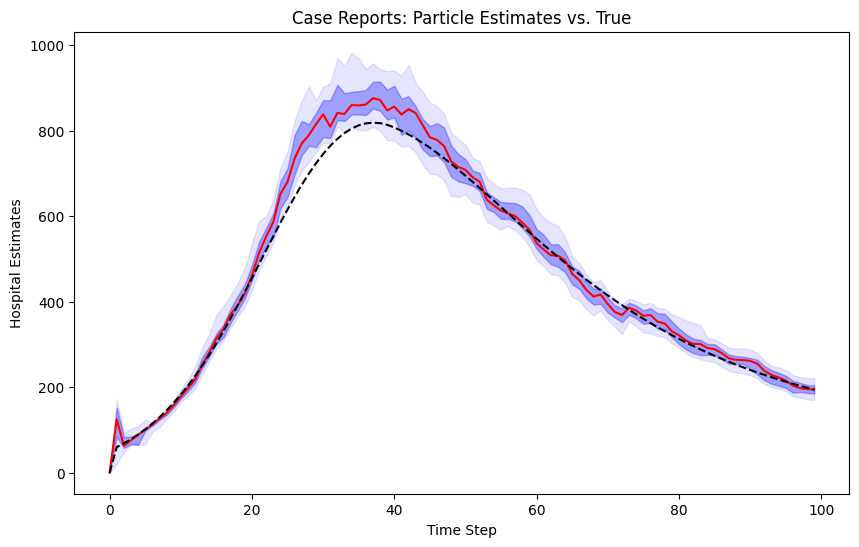

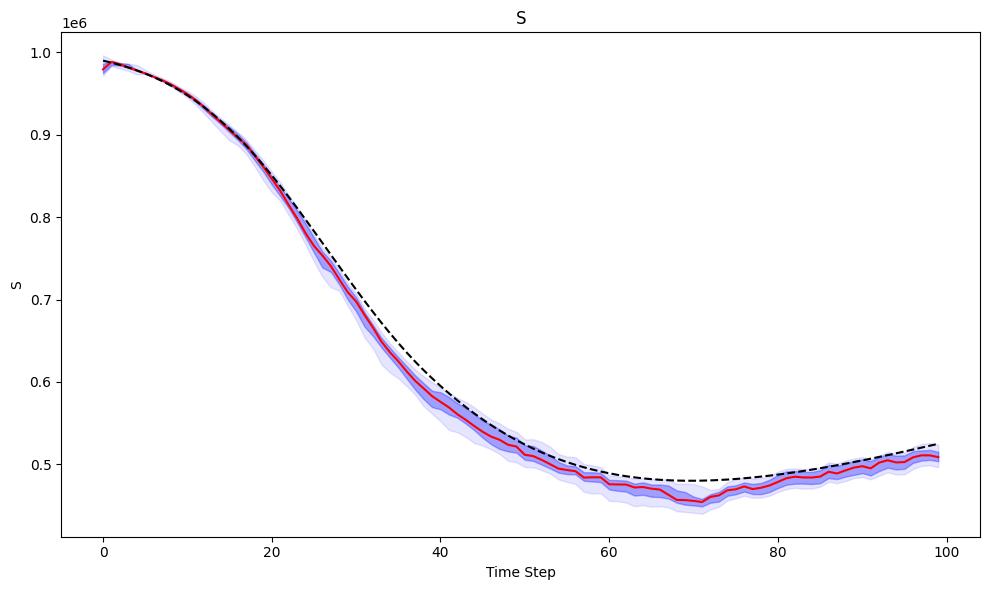

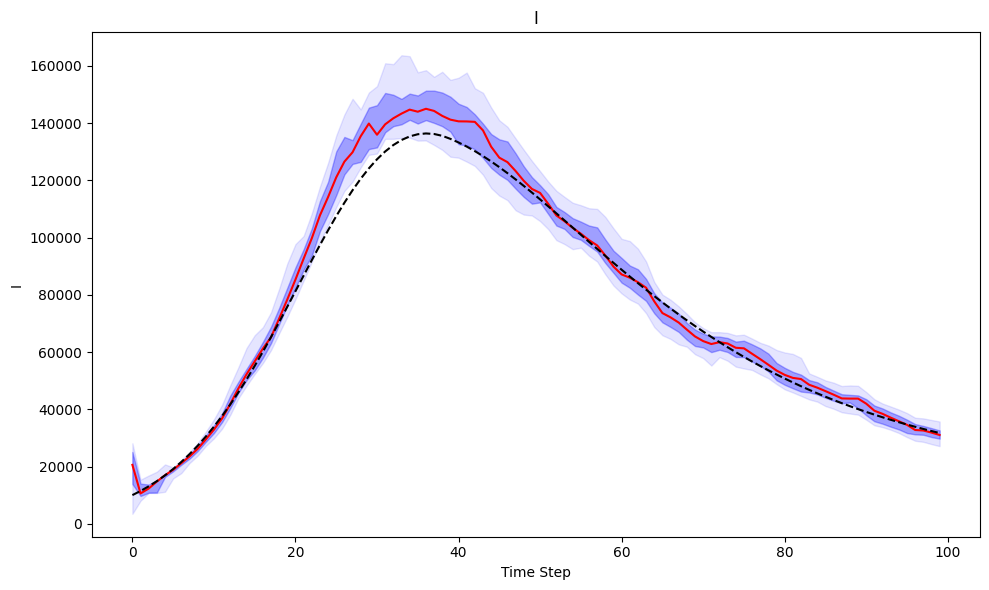

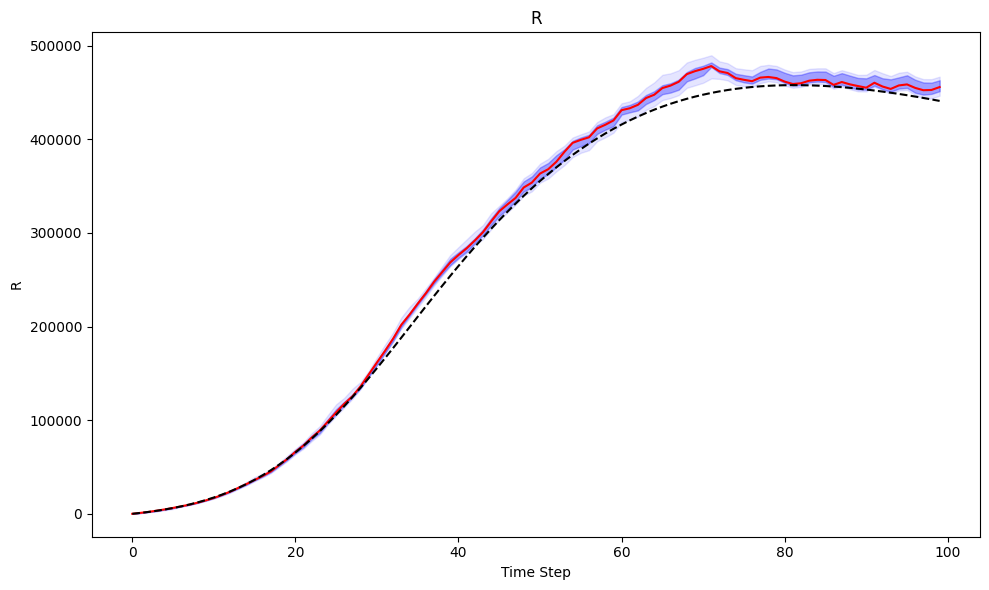

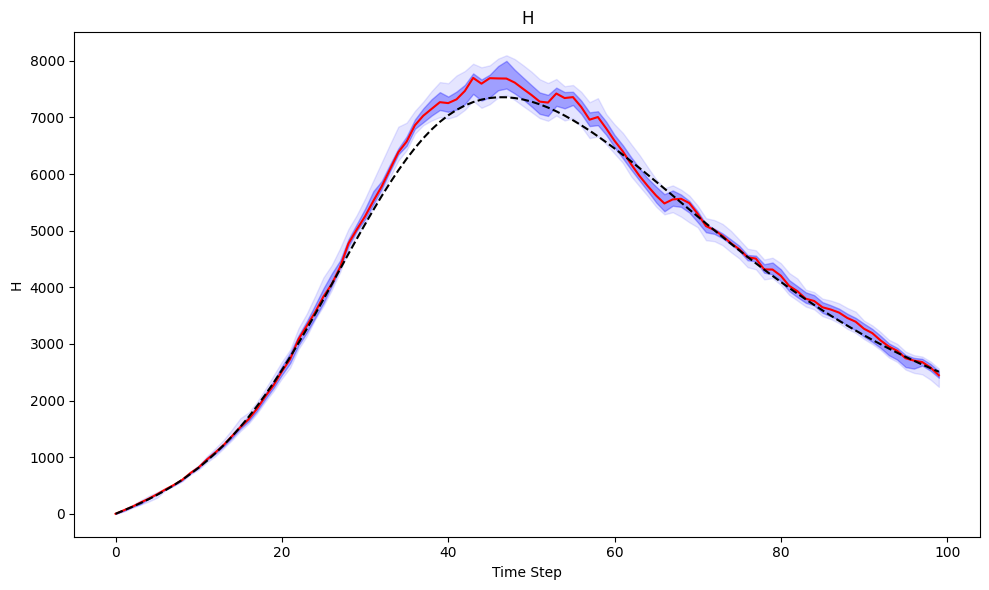

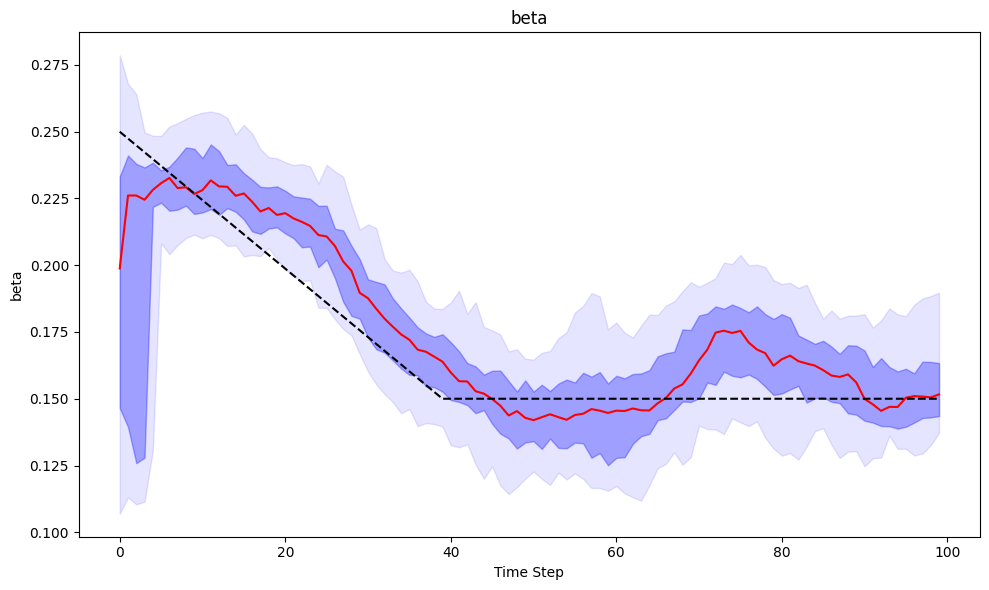

In [5]:
import importlib

importlib.reload(src.particle_filter.plotting)
from src.particle_filter.plotting import generate_plots


generate_plots(
    generated_data=det_output,
    true_beta=step_beta,
    particle_estimates=pmcmc_algo.mle_hospitalizations,
    reported_hosp=case_reports,
    pf_states=pmcmc_algo.mle_states,
)

In [6]:
pmcmc_algo

In [7]:
import jax.numpy as jnp

print("Acceptance Record:")
print(jnp.mean(pmcmc_algo._accept_record).item())

Acceptance Record:
0.0


In [8]:
print("theta values at each iteration:")
print(pmcmc_algo._thetas)

theta values at each iteration:
[[50.]]


It had not yet converged. We need many more iterations. Need to optimize the code, and run it on Monsoon HPC. 